In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree, ensemble
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import load_iris
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        imputer = SimpleImputer(strategy="median")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

In [3]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        column_names = ["Female", "Male"]
        for i in range(len(column_names)):
            X[column_names[i]] = matrix.T[i]
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        column_names = ["France", "Ireland", "Southham"]
        for i in range(len(column_names)):
            X[column_names[i]] = matrix.T[i]
        matrix = encoder.fit_transform(X[['Pclass']]).toarray()
        column_names = ["UpperClass", "MidClass", "WorkClass"]
        for i in range(len(column_names)):
            X[column_names[i]] = matrix.T[i]
        return X

In [4]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(["Name", "Ticket", "Sex", "Embarked", "Pclass", "Parch", "SibSp", "Cabin", "Age", "Fare"], axis=1)

In [5]:
titanic_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
print(test_data.head(11))
titanic_data.head(11)

    PassengerId  Pclass                                          Name     Sex  \
0           892       3                              Kelly, Mr. James    male   
1           893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2           894       2                     Myles, Mr. Thomas Francis    male   
3           895       3                              Wirz, Mr. Albert    male   
4           896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   
5           897       3                    Svensson, Mr. Johan Cervin    male   
6           898       3                          Connolly, Miss. Kate  female   
7           899       2                  Caldwell, Mr. Albert Francis    male   
8           900       3     Abrahim, Mrs. Joseph (Sophie Halaut Easu)  female   
9           901       3                       Davies, Mr. John Samuel    male   
10          902       3                              Ilieff, Mr. Ylio    male   

     Age  SibSp  Parch     

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
print(test_data.info())
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pcl

In [7]:
count = len(titanic_data)
print(count)
print(test_data.describe())
titanic_data.describe()

891
       PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188
std     120.810458    0.841838   14.181209    0.896760    0.981429   55.907576
min     892.000000    1.000000    0.170000    0.000000    0.000000    0.000000
25%     996.250000    1.000000   21.000000    0.000000    0.000000    7.895800
50%    1100.500000    3.000000   27.000000    0.000000    0.000000   14.454200
75%    1204.750000    3.000000   39.000000    1.000000    0.000000   31.500000
max    1309.000000    3.000000   76.000000    8.000000    9.000000  512.329200


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


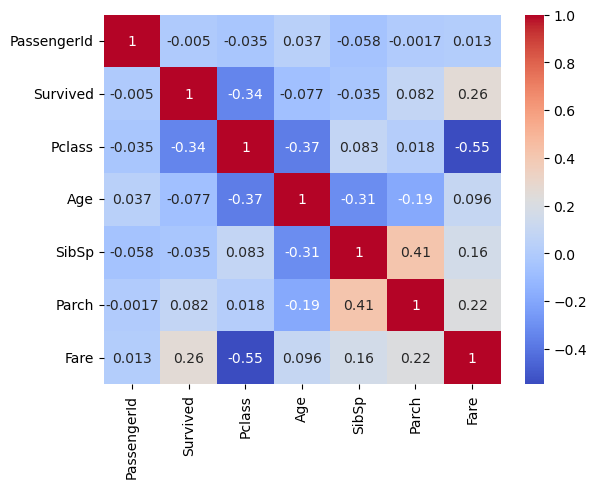

In [8]:
numerical_df = titanic_data.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [9]:
columns = titanic_data.columns.values
print('Number of columns in the training data is:', (len(columns)))
for col in columns:
    print('Number of missing training values in the', col, 'column is:', len(titanic_data[titanic_data[col].isnull()]))
    if (col == 'Embarked'):
        print(titanic_data[titanic_data[col].isnull()])
    if (col == 'Age'):
        AgeNaN = titanic_data[titanic_data[col].isnull()]
    if (col == 'Cabin'):
        CabinNaN = titanic_data[titanic_data[col].isnull()]
print('There are', len(titanic_data[titanic_data.isnull().any(axis=1)]), 'rows with missing values')

Number of columns in the training data is: 12
Number of missing training values in the PassengerId column is: 0
Number of missing training values in the Survived column is: 0
Number of missing training values in the Pclass column is: 0
Number of missing training values in the Name column is: 0
Number of missing training values in the Sex column is: 0
Number of missing training values in the Age column is: 177
Number of missing training values in the SibSp column is: 0
Number of missing training values in the Parch column is: 0
Number of missing training values in the Ticket column is: 0
Number of missing training values in the Fare column is: 0
Number of missing training values in the Cabin column is: 687
Number of missing training values in the Embarked column is: 2
     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelso

In [10]:
columns = test_data.columns.values
print('Number of columns in the test data is:', (len(columns)))
for col in columns:
    print('Number of missing test values in the', col, 'column is:', len(test_data[test_data[col].isnull()]))
    if (col == 'Embarked'):
        print(test_data[test_data[col].isnull()])
    if (col == 'Age'):
        AgeNaN_T = test_data[test_data[col].isnull()]
    if (col == 'Cabin'):
        CabinNaN_T = test_data[test_data[col].isnull()]
print('There are', len(test_data[test_data.isnull().any(axis=1)]), 'rows with missing values')

Number of columns in the test data is: 11
Number of missing test values in the PassengerId column is: 0
Number of missing test values in the Pclass column is: 0
Number of missing test values in the Name column is: 0
Number of missing test values in the Sex column is: 0
Number of missing test values in the Age column is: 86
Number of missing test values in the SibSp column is: 0
Number of missing test values in the Parch column is: 0
Number of missing test values in the Ticket column is: 0
Number of missing test values in the Fare column is: 1
Number of missing test values in the Cabin column is: 327
Number of missing test values in the Embarked column is: 0
Empty DataFrame
Columns: [PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []
There are 331 rows with missing values


In [11]:
print(AgeNaN.index)
AgeNaN.head(11)

Index([  5,  17,  19,  26,  28,  29,  31,  32,  36,  42,
       ...
       832, 837, 839, 846, 849, 859, 863, 868, 878, 888],
      dtype='int64', length=177)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
29,30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
32,33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C
42,43,0,3,"Kraeff, Mr. Theodor",male,NaN,0,0,349253,7.8958,NaN,C


In [12]:
print(CabinNaN.index)
CabinNaN.head(11)

Index([  0,   2,   4,   5,   7,   8,   9,  12,  13,  14,
       ...
       878, 880, 881, 882, 883, 884, 885, 886, 888, 890],
      dtype='int64', length=687)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S


In [13]:
pipeline2 = Pipeline([
    ('imputer', AgeImputer()),
    ('encoder', FeatureEncoder()),
    ('dropper', FeatureDropper())
])

In [14]:
pipeline1 = Pipeline([
    ('encoder', FeatureEncoder()),
    ('dropper', FeatureDropper())
])

In [15]:
strat_titanic_data = pipeline1.fit_transform(titanic_data)
strat_test_data = pipeline2.fit_transform(test_data)
#strat_titanic_data = titanic_data.drop(["Name", "Ticket", "Sex", "Parch", "SibSp", "Pclass", "Embarked", "Age", "Cabin", "Fare"], axis=1)

In [16]:
#strat_titanic_data = pipeline.fit_transform(titanic_data)
strat_titanic_data["Female"] = strat_titanic_data["Female"].astype(int)
strat_titanic_data["Male"] = strat_titanic_data["Male"].astype(int)
strat_titanic_data["France"] = strat_titanic_data["France"].astype(int)
strat_titanic_data["Ireland"] = strat_titanic_data["Ireland"].astype(int)
strat_titanic_data["Southham"] = strat_titanic_data["Southham"].astype(int)
strat_titanic_data["UpperClass"] = strat_titanic_data["UpperClass"].astype(int)
strat_titanic_data["MidClass"] = strat_titanic_data["MidClass"].astype(int)
strat_titanic_data["WorkClass"] = strat_titanic_data["WorkClass"].astype(int)
strat_titanic_data.head(11)

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
0,1,0,0,1,0,0,1,0,0,1
1,2,1,1,0,1,0,0,1,0,0
2,3,1,1,0,0,0,1,0,0,1
3,4,1,1,0,0,0,1,1,0,0
4,5,0,0,1,0,0,1,0,0,1
5,6,0,0,1,0,1,0,0,0,1
6,7,0,0,1,0,0,1,1,0,0
7,8,0,0,1,0,0,1,0,0,1
8,9,1,1,0,0,0,1,0,0,1
9,10,1,1,0,1,0,0,0,1,0


In [17]:
#strat_titanic_data = pipeline.fit_transform(titanic_data)
strat_test_data["Female"] = strat_test_data["Female"].astype(int)
strat_test_data["Male"] = strat_test_data["Male"].astype(int)
strat_test_data["France"] = strat_test_data["France"].astype(int)
strat_test_data["Ireland"] = strat_test_data["Ireland"].astype(int)
strat_test_data["Southham"] = strat_test_data["Southham"].astype(int)
strat_test_data["UpperClass"] = strat_test_data["UpperClass"].astype(int)
strat_test_data["MidClass"] = strat_test_data["MidClass"].astype(int)
strat_test_data["WorkClass"] = strat_test_data["WorkClass"].astype(int)
strat_test_data.head(11)

,PassengerId,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
0,892,0,1,0,1,0,0,0,1
1,893,1,0,0,0,1,0,0,1
2,894,0,1,0,1,0,0,1,0
3,895,0,1,0,0,1,0,0,1
4,896,1,0,0,0,1,0,0,1
5,897,0,1,0,0,1,0,0,1
6,898,1,0,0,1,0,0,0,1
7,899,0,1,0,0,1,0,1,0
8,900,1,0,1,0,0,0,0,1
9,901,0,1,0,0,1,0,0,1


In [18]:
strat_titanic_data.iloc[AgeNaN.head(11).index]

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
5,6,0,0,1,0,1,0,0,0,1
17,18,1,0,1,0,0,1,0,1,0
19,20,1,1,0,1,0,0,0,0,1
26,27,0,0,1,1,0,0,0,0,1
28,29,1,1,0,0,1,0,0,0,1
29,30,0,0,1,0,0,1,0,0,1
31,32,1,1,0,1,0,0,1,0,0
32,33,1,1,0,0,1,0,0,0,1
36,37,1,0,1,1,0,0,0,0,1
42,43,0,0,1,1,0,0,0,0,1


In [19]:
strat_test_data.iloc[AgeNaN_T.head(11).index]

,PassengerId,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
10,902,0,1,0,0,1,0,0,1
22,914,1,0,0,0,1,1,0,0
29,921,0,1,1,0,0,0,0,1
33,925,1,0,0,0,1,0,0,1
36,928,1,0,0,0,1,0,0,1
39,931,0,1,0,0,1,0,0,1
41,933,0,1,0,0,1,1,0,0
47,939,0,1,0,1,0,0,0,1
54,946,0,1,1,0,0,0,1,0
58,950,0,1,0,0,1,0,0,1


In [156]:
#strat_titanic_data.iloc[CabinNaN.head(11).index]

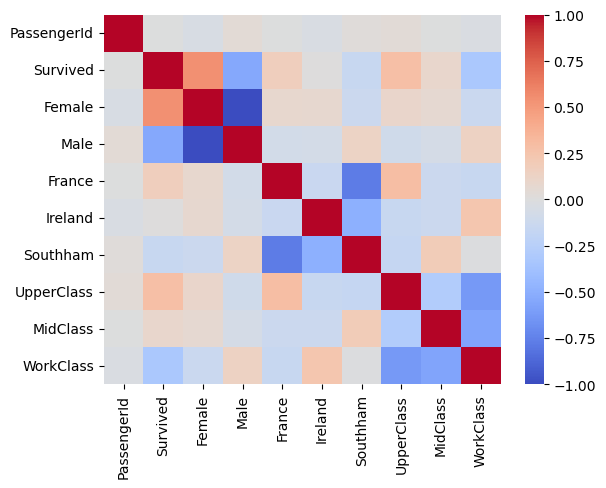

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
PassengerId,1.000000,-0.005007,-0.042939,0.042939,-0.001205,-0.033606,0.022148,0.034303,-0.000086,-0.029486
Survived,-0.005007,1.000000,0.543351,-0.543351,0.168240,0.003650,-0.155660,0.285904,0.093349,-0.322308
Female,-0.042939,0.543351,1.000000,-1.000000,0.082853,0.074115,-0.125722,0.098013,0.064746,-0.137143
Male,0.042939,-0.543351,-1.000000,1.000000,-0.082853,-0.074115,0.125722,-0.098013,-0.064746,0.137143
France,-0.001205,0.168240,0.082853,-0.082853,1.000000,-0.148258,-0.778359,0.296423,-0.125416,-0.153329
Ireland,-0.033606,0.003650,0.074115,-0.074115,-0.148258,1.000000,-0.496624,-0.155342,-0.127301,0.237449
Southham,0.022148,-0.155660,-0.125722,0.125722,-0.778359,-0.496624,1.000000,-0.170379,0.192061,-0.009511
UpperClass,0.034303,0.285904,0.098013,-0.098013,0.296423,-0.155342,-0.170379,1.000000,-0.288585,-0.626738
MidClass,-0.000086,0.093349,0.064746,-0.064746,-0.125416,-0.127301,0.192061,-0.288585,1.000000,-0.565210
WorkClass,-0.029486,-0.322308,-0.137143,0.137143,-0.153329,0.237449,-0.009511,-0.626738,-0.565210,1.000000


In [20]:
numerical_df = strat_titanic_data.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()
correlation_matrix

In [158]:
#Female = np.eye(count, 1, dtype=int)
#for i in range(count):
#    if (titanic_data.iloc[i]["Sex"] == "female"):
#        Female[i] = 1
#    else:
#        Female[i] = 0
#Female = pd.DataFrame(Female)
#strat_titanic_data["Female"] = Female

In [21]:
#strat_titanic_data["Female"] = strat_titanic_data['Female'].astype(int)
#strat_titanic_data["Male"] = strat_titanic_data['Male'].astype(int)
strat_titanic_data.head(11)

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
0,1,0,0,1,0,0,1,0,0,1
1,2,1,1,0,1,0,0,1,0,0
2,3,1,1,0,0,0,1,0,0,1
3,4,1,1,0,0,0,1,1,0,0
4,5,0,0,1,0,0,1,0,0,1
5,6,0,0,1,0,1,0,0,0,1
6,7,0,0,1,0,0,1,1,0,0
7,8,0,0,1,0,0,1,0,0,1
8,9,1,1,0,0,0,1,0,0,1
9,10,1,1,0,1,0,0,0,1,0


In [22]:
columns = strat_titanic_data.columns.values
print('Number of columns in the training data is:', (len(columns)))
for col in columns:
    print('Number of missing training values in the', col, 'column is:', len(strat_titanic_data[strat_titanic_data[col].isnull()]))
    if (col == 'Embarked'):
        print(strat_titanic_data[strat_titanic_data[col].isnull()])
    #if (col == 'Age'):
        #AgeNaN = strat_titanic_data[strat_titanic_data[col].isnull()]
    #if (col == 'Cabin'):
        #CabinNaN = strat_titanic_data[strat_titanic_data[col].isnull()]
print('There are', len(strat_titanic_data[strat_titanic_data.isnull().any(axis=1)]), 'rows with missing values')

Number of columns in the training data is: 10
Number of missing training values in the PassengerId column is: 0
Number of missing training values in the Survived column is: 0
Number of missing training values in the Female column is: 0
Number of missing training values in the Male column is: 0
Number of missing training values in the France column is: 0
Number of missing training values in the Ireland column is: 0
Number of missing training values in the Southham column is: 0
Number of missing training values in the UpperClass column is: 0
Number of missing training values in the MidClass column is: 0
Number of missing training values in the WorkClass column is: 0
There are 0 rows with missing values


In [23]:
columns = strat_test_data.columns.values
print('Number of columns in the training data is:', (len(columns)))
for col in columns:
    print('Number of missing training values in the', col, 'column is:', len(strat_test_data[strat_test_data[col].isnull()]))
    if (col == 'Embarked'):
        print(strat_test_data[strat_test_data[col].isnull()])
    #if (col == 'Age'):
        #AgeNaN = strat_test_data[strat_test_data[col].isnull()]
    #if (col == 'Cabin'):
        #CabinNaN = strat_ttest_data[strat_test_data[col].isnull()]
print('There are', len(strat_test_data[strat_test_data.isnull().any(axis=1)]), 'rows with missing values')

Number of columns in the training data is: 9
Number of missing training values in the PassengerId column is: 0
Number of missing training values in the Female column is: 0
Number of missing training values in the Male column is: 0
Number of missing training values in the France column is: 0
Number of missing training values in the Ireland column is: 0
Number of missing training values in the Southham column is: 0
Number of missing training values in the UpperClass column is: 0
Number of missing training values in the MidClass column is: 0
Number of missing training values in the WorkClass column is: 0
There are 0 rows with missing values


In [195]:
#pd.options.mode.copy_on_write = True
#Embarked = np.eye(count, 1, dtype=int)
#for i in range(count):
#    if(titanic_data.iloc[i]["Embarked"] == "Q"):
#        Embarked[i] = 0
#    elif (titanic_data.iloc[i]["Embarked"] == "S"):
#        Embarked[i] = 0
#    elif (titanic_data.iloc[i]["Embarked"] == "C"):
#        Embarked[i] = 2
#    else:
#        Embarked[i] = 1
#Embarked = pd.DataFrame(Embarked)
#strat_titanic_data["Embarked"] = Embarked
#print(strat_titanic_data["Embarked"].value_counts())

In [181]:
#strat_titanic_data["Embarked"] = Embarked
#print(strat_titanic_data.iloc[61], strat_titanic_data.iloc[829])
#strat_titanic_data.head(11)

PassengerId    62.0
Survived        1.0
Fare           80.0
Female          1.0
Embarked        1.0
Name: 61, dtype: float64 PassengerId    830.0
Survived         1.0
Fare            80.0
Female           1.0
Embarked         1.0
Name: 829, dtype: float64


,PassengerId,Survived,Fare,Female,Embarked
0,1,0,7.2500,0,0
1,2,1,71.2833,1,2
2,3,1,7.9250,1,0
3,4,1,53.1000,1,0
4,5,0,8.0500,0,0
5,6,0,8.4583,0,0
6,7,0,51.8625,0,0
7,8,0,21.0750,0,0
8,9,1,11.1333,1,0
9,10,1,30.0708,1,2


In [24]:
columns = strat_titanic_data.columns.values
print('Number of columns in the training data is:', (len(columns)))
for col in columns:
    print('Number of missing training values in the', col, 'column is:', len(strat_titanic_data[strat_titanic_data[col].isnull()]))
    if (col == 'Embarked'):
        print(strat_titanic_data[strat_titanic_data[col].isnull()])
    #if (col == 'Age'):
        #AgeNaN = strat_titanic_data[strat_titanic_data[col].isnull()]
    #if (col == 'Cabin'):
        #CabinNaN = strat_titanic_data[strat_titanic_data[col].isnull()]
print('There are', len(strat_titanic_data[strat_titanic_data.isnull().any(axis=1)]), 'rows with missing values')

Number of columns in the training data is: 10
Number of missing training values in the PassengerId column is: 0
Number of missing training values in the Survived column is: 0
Number of missing training values in the Female column is: 0
Number of missing training values in the Male column is: 0
Number of missing training values in the France column is: 0
Number of missing training values in the Ireland column is: 0
Number of missing training values in the Southham column is: 0
Number of missing training values in the UpperClass column is: 0
Number of missing training values in the MidClass column is: 0
Number of missing training values in the WorkClass column is: 0
There are 0 rows with missing values


In [25]:
titanic_data["Fare"].median

<bound method Series.median of 0       7.2500
1      71.2833
2       7.9250
3      53.1000
4       8.0500
        ...   
886    13.0000
887    30.0000
888    23.4500
889    30.0000
890     7.7500
Name: Fare, Length: 891, dtype: float64>

In [26]:
DeckA = np.eye(count, 1, dtype=int)
DeckB = np.eye(count, 1, dtype=int) 
DeckC = np.eye(count, 1, dtype=int)
DeckD = np.eye(count, 1, dtype=int)
DeckE = np.eye(count, 1, dtype=int)
DeckF = np.eye(count, 1, dtype=int)
DeckG = np.eye(count, 1, dtype=int)
#for i in range(count):
#    if (titanic_data.iloc[i]["Pclass"] == 1):
#        DeckC[i] = 1
#    elif (titanic_data.iloc[i]["Fare"] > 55):
#        DeckB[i] = 1
#    elif ((titanic_data.iloc[i]["Pclass"] == 1) & (titanic_data.iloc[i]["Fare"] > 18) & (titanic_data.iloc[i]["Fare"] < 56)):
#        DeckD[i] = 1
#    elif (titanic_data.iloc[i]["Pclass"] == 2):
#        DeckE[i] = 1
#    elif ((titanic_data.iloc[i]["Fare"] > 18) & (titanic_data.iloc[i]["Fare"] < 56)):
#        DeckF[i] = 1
#    elif ((titanic_data.iloc[i]["Fare"] > 11) & (titanic_data.iloc[i]["Fare"] < 18)):
#        DeckG[i] = 1
#    else:
#        DeckA[i] = 0

has_A = titanic_data["Cabin"].str.contains('A')
has_B = titanic_data["Cabin"].str.contains('B')
has_C = titanic_data["Cabin"].str.contains('C')
has_D = titanic_data["Cabin"].str.contains('D')
has_E = titanic_data["Cabin"].str.contains('E')
has_F = titanic_data["Cabin"].str.contains('F')
has_G = titanic_data["Cabin"].str.contains('G')

for i in range(len(strat_titanic_data)):
    if (has_A[i] == True):
        DeckA[i] = 1
    elif (has_B[i] == True):
        DeckB[i] = 1
    elif (has_C[i] == True):
        DeckC[i]=1
    elif (has_D[i] == True):
        DeckD[i] = 1
    elif (has_E[i] == True):
        DeckE[i] = 1
    elif (has_F[i] == True):
        DeckF[i] = 1
    elif (has_G[i] == True):
        DeckG[i] = 1
    else:
        DeckA[i] = 0
        DeckB[i] = 0
        DeckC[i] = 0
        DeckD[i] = 0
        DeckE[i] = 0
        DeckF[i] = 0
        DeckG[i] = 0

DeckA = pd.DataFrame(DeckA)
DeckB = pd.DataFrame(DeckB)
DeckC = pd.DataFrame(DeckC)
DeckD = pd.DataFrame(DeckD)
DeckE = pd.DataFrame(DeckE)
DeckF = pd.DataFrame(DeckF)
DeckG = pd.DataFrame(DeckG)

strat_titanic_data["DeckA"] = DeckA
strat_titanic_data["DeckB"] = DeckB
strat_titanic_data["DeckC"] = DeckC
strat_titanic_data["DeckD"] = DeckD
strat_titanic_data["DeckE"] = DeckE
strat_titanic_data["DeckF"] = DeckF
strat_titanic_data["DeckG"] = DeckG
print(strat_titanic_data["DeckA"].value_counts())
print(strat_titanic_data["DeckB"].value_counts())
print(strat_titanic_data["DeckC"].value_counts())
print(strat_titanic_data["DeckD"].value_counts())
print(strat_titanic_data["DeckE"].value_counts())
print(strat_titanic_data["DeckF"].value_counts())
print(strat_titanic_data["DeckG"].value_counts())

DeckA
0    876
1     15
Name: count, dtype: int64
DeckB
0    844
1     47
Name: count, dtype: int64
DeckC
0    832
1     59
Name: count, dtype: int64
DeckD
0    858
1     33
Name: count, dtype: int64
DeckE
0    858
1     33
Name: count, dtype: int64
DeckF
0    879
1     12
Name: count, dtype: int64
DeckG
0    887
1      4
Name: count, dtype: int64


In [27]:
strat_titanic_data.head(11)

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,DeckC,DeckD,DeckE,DeckF,DeckG
0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
1,2,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0
2,3,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,4,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0
4,5,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
5,6,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0
6,7,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0
7,8,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
8,9,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
9,10,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [28]:
columns = strat_titanic_data.columns.values
print('Number of columns in the training data is:', (len(columns)))
for col in columns:
    print('Number of missing training values in the', col, 'column is:', len(strat_titanic_data[strat_titanic_data[col].isnull()]))
    if (col == 'Embarked'):
        print(strat_titanic_data[strat_titanic_data[col].isnull()])
    #if (col == 'Age'):
        #AgeNaN = strat_titanic_data[strat_titanic_data[col].isnull()]
    #if (col == 'Cabin'):
        #CabinNaN = strat_titanic_data[strat_titanic_data[col].isnull()]
print('There are', len(strat_titanic_data[strat_titanic_data.isnull().any(axis=1)]), 'rows with missing values')

Number of columns in the training data is: 17
Number of missing training values in the PassengerId column is: 0
Number of missing training values in the Survived column is: 0
Number of missing training values in the Female column is: 0
Number of missing training values in the Male column is: 0
Number of missing training values in the France column is: 0
Number of missing training values in the Ireland column is: 0
Number of missing training values in the Southham column is: 0
Number of missing training values in the UpperClass column is: 0
Number of missing training values in the MidClass column is: 0
Number of missing training values in the WorkClass column is: 0
Number of missing training values in the DeckA column is: 0
Number of missing training values in the DeckB column is: 0
Number of missing training values in the DeckC column is: 0
Number of missing training values in the DeckD column is: 0
Number of missing training values in the DeckE column is: 0
Number of missing training 

In [29]:
strat_titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  891 non-null    int64
 1   Survived     891 non-null    int64
 2   Female       891 non-null    int64
 3   Male         891 non-null    int64
 4   France       891 non-null    int64
 5   Ireland      891 non-null    int64
 6   Southham     891 non-null    int64
 7   UpperClass   891 non-null    int64
 8   MidClass     891 non-null    int64
 9   WorkClass    891 non-null    int64
 10  DeckA        891 non-null    int64
 11  DeckB        891 non-null    int64
 12  DeckC        891 non-null    int64
 13  DeckD        891 non-null    int64
 14  DeckE        891 non-null    int64
 15  DeckF        891 non-null    int64
 16  DeckG        891 non-null    int64
dtypes: int64(17)
memory usage: 118.5 KB


In [30]:
strat_titanic_data.describe()

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,DeckC,DeckD,DeckE,DeckF,DeckG
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,0.352413,0.647587,0.188552,0.086420,0.722783,0.242424,0.206510,0.551066,0.016835,0.052750,0.066218,0.037037,0.037037,0.013468,0.004489
std,257.353842,0.486592,0.477990,0.477990,0.391372,0.281141,0.447876,0.428790,0.405028,0.497665,0.128725,0.223659,0.248802,0.188959,0.188959,0.115332,0.066890
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,668.500000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,891.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


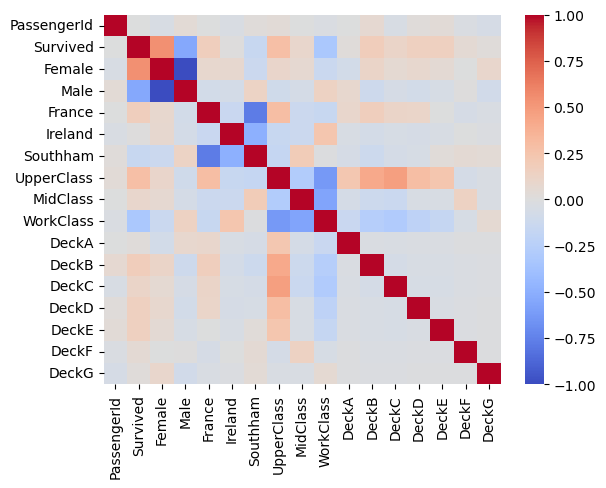

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,DeckC,DeckD,DeckE,DeckF,DeckG
PassengerId,1.000000,-0.005007,-0.042939,0.042939,-0.001205,-0.033606,0.022148,0.034303,-0.000086,-0.029486,-0.003256,0.069552,-0.040957,0.022828,0.034404,-0.025212,-0.060049
Survived,-0.005007,1.000000,0.543351,-0.543351,0.168240,0.003650,-0.155660,0.285904,0.093349,-0.322308,0.022287,0.175095,0.114652,0.150716,0.150716,0.047930,0.016040
Female,-0.042939,0.543351,1.000000,-1.000000,0.082853,0.074115,-0.125722,0.098013,0.064746,-0.137143,-0.078271,0.109689,0.058649,0.079248,0.054368,-0.004667,0.091031
Male,0.042939,-0.543351,-1.000000,1.000000,-0.082853,-0.074115,0.125722,-0.098013,-0.064746,0.137143,0.078271,-0.109689,-0.058649,-0.079248,-0.054368,0.004667,-0.091031
France,-0.001205,0.168240,0.082853,-0.082853,1.000000,-0.148258,-0.778359,0.296423,-0.125416,-0.153329,0.093040,0.168642,0.113952,0.102977,-0.003376,-0.056322,-0.032371
Ireland,-0.033606,0.003650,0.074115,-0.074115,-0.148258,1.000000,-0.496624,-0.155342,-0.127301,0.237449,-0.040246,-0.072579,-0.049776,-0.060318,-0.039167,-0.001283,-0.020654
Southham,0.022148,-0.155660,-0.125722,0.125722,-0.778359,-0.496624,1.000000,-0.170379,0.192061,-0.009511,-0.055383,-0.123057,-0.066995,-0.051139,0.028520,0.050608,0.041589
UpperClass,0.034303,0.285904,0.098013,-0.098013,0.296423,-0.155342,-0.170379,1.000000,-0.288585,-0.626738,0.231323,0.417160,0.470749,0.291218,0.235748,-0.066095,-0.037988
MidClass,-0.000086,0.093349,0.064746,-0.064746,-0.125416,-0.127301,0.192061,-0.288585,1.000000,-0.565210,-0.066756,-0.120386,-0.135851,-0.041325,-0.041325,0.132819,-0.034258
WorkClass,-0.029486,-0.322308,-0.137143,0.137143,-0.153329,0.237449,-0.009511,-0.626738,-0.565210,1.000000,-0.144979,-0.261450,-0.295036,-0.217282,-0.169489,-0.051148,0.060612


In [31]:
numerical_df = strat_titanic_data.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()
correlation_matrix

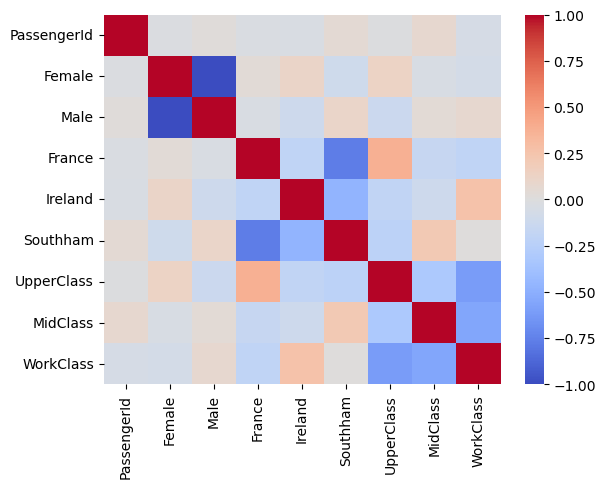

,PassengerId,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
PassengerId,1.000000,-0.023245,0.023245,-0.027419,-0.035731,0.048008,-0.011062,0.077295,-0.054692
Female,-0.023245,1.000000,-1.000000,0.033684,0.115574,-0.105883,0.126389,-0.045655,-0.072405
Male,0.023245,-1.000000,1.000000,-0.033684,-0.115574,0.105883,-0.126389,0.045655,0.072405
France,-0.027419,0.033684,-0.033684,1.000000,-0.199786,-0.767375,0.381492,-0.156605,-0.202894
Ireland,-0.035731,0.115574,-0.115574,-0.199786,1.000000,-0.474962,-0.188745,-0.114588,0.260301
Southham,0.048008,-0.105883,0.105883,-0.767375,-0.474962,1.000000,-0.219110,0.215634,0.011883
UpperClass,-0.011062,0.126389,-0.126389,0.381492,-0.188745,-0.219110,1.000000,-0.313770,-0.612386
MidClass,0.077295,-0.045655,0.045655,-0.156605,-0.114588,0.215634,-0.313770,1.000000,-0.558487
WorkClass,-0.054692,-0.072405,0.072405,-0.202894,0.260301,0.011883,-0.612386,-0.558487,1.000000


In [32]:
numerical_T_df = strat_test_data.select_dtypes(include=[np.number])
correlation_matrix_T = numerical_T_df.corr()
sns.heatmap(correlation_matrix_T, annot=False, cmap='coolwarm')
plt.show()
correlation_matrix_T

In [33]:
Infant = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Age"] <= 5):
        Infant[i] = 1
    else:
        Infant[i] = 0
Infant = pd.DataFrame(Infant)
strat_titanic_data["Infant"] = Infant
print(strat_titanic_data["Infant"].value_counts())

Infant
0    847
1     44
Name: count, dtype: int64


In [34]:
Older = np.eye(count, 1, dtype=int)
VOld = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Age"] > 63) & (titanic_data.iloc[i]["Age"] < 75):
        Older[i] = 1
    elif (titanic_data.iloc[i]["Age"] > 74):
        VOld[i] = 1
    else:
        Older[i] = 0
        VOld[i] = 0
Older = pd.DataFrame(Older)
VOld = pd.DataFrame(VOld)
strat_titanic_data["Older"] = Older
strat_titanic_data["VOld"] = VOld
print(strat_titanic_data["Older"].value_counts())
print(strat_titanic_data["VOld"].value_counts())

Older
0    879
1     12
Name: count, dtype: int64
VOld
0    890
1      1
Name: count, dtype: int64


In [35]:
Teen = np.eye(count, 1, dtype=int)
Child = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Age"] > 12) & (titanic_data.iloc[i]["Age"] <= 18):
        Teen[i] = 1
    elif (titanic_data.iloc[i]["Age"] > 5) & (titanic_data.iloc[i]["Age"] <= 12):
        Child[i] = 1     
    else:
        Teen[i] = 0
        Child[i] = 0
Teen = pd.DataFrame(Teen)
Child = pd.DataFrame(Child)
strat_titanic_data["Teen"] = Teen
strat_titanic_data["Child"] = Child
print(strat_titanic_data["Teen"].value_counts())
print(strat_titanic_data["Child"].value_counts())

Teen
0    821
1     70
Name: count, dtype: int64
Child
0    866
1     25
Name: count, dtype: int64


In [36]:
Adult = np.eye(count, 1, dtype=int)
MidLife = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Age"] > 18) & (titanic_data.iloc[i]["Age"] <= 40):
        Adult[i] = 1
    elif (titanic_data.iloc[i]["Age"] > 40) & (titanic_data.iloc[i]["Age"] <= 63):
        MidLife[i] = 1
    else:
        Adult[i] = 0
        MidLife[i] = 0
Adult = pd.DataFrame(Adult)
MidLife = pd.DataFrame(MidLife)
strat_titanic_data["Adult"] = Adult
strat_titanic_data["MidLife"] = MidLife
print(strat_titanic_data["Adult"].value_counts())
print(strat_titanic_data["MidLife"].value_counts())

Adult
0    466
1    425
Name: count, dtype: int64
MidLife
0    753
1    138
Name: count, dtype: int64


In [539]:
#print(strat_titanic_data["Age"].value_counts())
#print(strat_titanic_data["Age"].median())
#print(strat_titanic_data["Age"].mean())
#print(strat_titanic_data["Age"].max())

In [37]:
#strat_titanic_data["Female"] = strat_titanic_data['Female'].astype(int)
#strat_titanic_data["Male"] = strat_titanic_data['Male'].astype(int)
strat_titanic_data.head(11)

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass,...,DeckE,DeckF,DeckG,Infant,Older,VOld,Teen,Child,Adult,MidLife
0,1,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
1,2,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,1,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,4,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
5,6,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,1,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1
7,8,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
8,9,1,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
9,10,1,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [203]:
#Class = np.eye(count, 1, dtype=int)
#for i in range(count):
#    if (titanic_data.iloc[i]["Pclass"] == 1):
#        Class[i] = 2
#    elif (titanic_data.iloc[i]["Pclass"] == 2):
#        Class[i] = 1
#    else:
#        Class[i] = 0
#Class = pd.DataFrame(Class)
#strat_titanic_data["Class"] = Class
#strat_titanic_data.head(11)

,PassengerId,Survived,Fare,Female,Embarked,Cabin,Infant,Class
0,1,0,7.2500,0,0,0,0,0
1,2,1,71.2833,1,2,4,0,2
2,3,1,7.9250,1,0,0,0,0
3,4,1,53.1000,1,0,4,0,2
4,5,0,8.0500,0,0,0,0,0
5,6,0,8.4583,0,0,0,0,0
6,7,0,51.8625,0,0,2,0,2
7,8,0,21.0750,0,0,2,1,0
8,9,1,11.1333,1,0,1,0,0
9,10,1,30.0708,1,2,2,0,1


In [38]:
Family = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Parch"] == 3):
        Family[i] = 5
    elif (titanic_data.iloc[i]["Parch"] == 1):
        Family[i] = 4
    elif (titanic_data.iloc[i]["Parch"] == 2):
        Family[i] = 3
    elif (titanic_data.iloc[i]["Parch"] == 0):
        Family[i] = 2
    elif (titanic_data.iloc[i]["Parch"] == 5):
        Family[i] = 1
    else:
        Family[i] = 0
Family = pd.DataFrame(Family)
strat_titanic_data["Family"] = Family
print(strat_titanic_data["Family"].value_counts())

Family
2    678
4    118
3     80
1      5
5      5
0      5
Name: count, dtype: int64


In [39]:
Sibling = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["SibSp"] == 1):
        Sibling[i] = 5
    elif (titanic_data.iloc[i]["SibSp"] == 2):
        Sibling[i] = 4
    elif (titanic_data.iloc[i]["SibSp"] == 0):
        Sibling[i] = 3
    elif (titanic_data.iloc[i]["SibSp"] == 3):
        Sibling[i] = 2
    elif (titanic_data.iloc[i]["SibSp"] == 4):
        Sibling[i] = 1
    else:
        Sibling[i] = 0
Sibling = pd.DataFrame(Sibling)
strat_titanic_data["Sibling"] = Sibling
print(strat_titanic_data["Sibling"].value_counts())

Sibling
3    608
5    209
4     28
1     18
2     16
0     12
Name: count, dtype: int64


In [40]:
#AgeFactor = np.eye(count, 1, dtype=int)
#for i in range(count):
#    if ((titanic_data.iloc[i]["Age"] > 18) & (titanic_data.iloc[i]["Age"] < 36)):
#        AgeFactor[i] = 2
#    elif ((titanic_data.iloc[i]["Age"] > 36) & (titanic_data.iloc[i]["Age"] < 64)):
#        AgeFactor[i] = 1
#    elif ((titanic_data.iloc[i]["Age"] > 5) & (titanic_data.iloc[i]["Age"] <=18)):
#        AgeFactor[i] = 0
#    elif ((titanic_data.iloc[i]["Age"] > 64) & (titanic_data.iloc[i]["Age"] < 76)):
#        AgeFactor[i] = 0
#    else:
#        AgeFactor[i] = 1
#Age = pd.DataFrame(AgeFactor)
#strat_titanic_data["AgeFactor"] = AgeFactor
#strat_titanic_data["AgeFactor"].value_counts()

In [1098]:
#Age = np.eye(count, 1, dtype=float)
#for i in range(count):
#    Age[i] = titanic_data.iloc[i]["Age"]
#for i in (AgeNaN.index):
#    Age[i] = 40
#Age = pd.DataFrame(Age)
#strat_titanic_data["Age"] = Age
#strat_titanic_data.iloc[AgeNaN.head(11).index]

,Survived,Fare,Female,Male,France,Southham,UpperClass,MidClass,WorkClass,DeckA,...,DeckG,Infant,Older,VOld,Teen,Adult,MidLife,Family,Sibling,Age
5,0,8.4583,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,2,3,40.0
17,1,13.0000,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,0,2,3,40.0
19,1,7.2250,1,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,2,3,40.0
26,0,7.2250,0,1,1,0,0,0,1,0,...,0,0,0,0,0,1,0,2,3,40.0
28,1,7.8792,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,2,3,40.0
29,0,7.8958,0,1,0,1,0,0,1,0,...,0,0,0,0,0,1,0,2,3,40.0
31,1,146.5208,1,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,2,5,40.0
32,1,7.7500,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,2,3,40.0
36,1,7.2292,0,1,1,0,0,0,1,0,...,0,0,0,0,0,1,0,2,3,40.0
42,0,7.8958,0,1,1,0,0,0,1,0,...,0,0,0,0,0,1,0,2,3,40.0


In [40]:
FareSHigh = np.eye(count, 1, dtype=int)
FareVHigh = np.eye(count, 1, dtype=int)
FareHigh = np.eye(count, 1, dtype=int)
FareMid = np.eye(count, 1, dtype=int)
FareLMid = np.eye(count, 1, dtype=int)
FareLow = np.eye(count, 1, dtype=int)
FareVLow = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Fare"] > 300):
        FareSHigh[i] = 1
    elif ((titanic_data.iloc[i]["Fare"] > 200) & (titanic_data.iloc[i]["Fare"] <= 300)):
        FareVHigh[i] = 1
    elif ((titanic_data.iloc[i]["Fare"] > 100) & (titanic_data.iloc[i]["Fare"] <=200)):
        FareHigh[i] = 1
    elif ((titanic_data.iloc[i]["Fare"] > 50) & (titanic_data.iloc[i]["Fare"] <=100)):
        FareMid[i] = 1
    elif ((titanic_data.iloc[i]["Fare"] > 29) & (titanic_data.iloc[i]["Fare"] <= 50)):
        FareLMid[i] = 1
    elif ((titanic_data.iloc[i]["Fare"] > 10) & (titanic_data.iloc[i]["Fare"] <= 29)):
        FareLow[i] = 1
    elif (titanic_data.iloc[i]["Fare"] <= 10):
        FareVLow[i] = 1
    else:
        FareSHigh[i] = 0
        FareVHigh[i] = 0
        FareHigh[i] = 0
        FareMid[i] = 0
        FareLMid[i] = 0
        FareLow[i] = 0
        FareVLow[i] = 0
FareSHigh = pd.DataFrame(FareSHigh)
FareVHigh = pd.DataFrame(FareVHigh)
FareHigh = pd.DataFrame(FareHigh)
FareMid = pd.DataFrame(FareMid)
FareLMid = pd.DataFrame(FareLMid)
FareLow = pd.DataFrame(FareLow)
FareVLow = pd.DataFrame(FareVLow)
strat_titanic_data["FareSHigh"] = FareSHigh
strat_titanic_data["FareVHigh"] = FareVHigh
strat_titanic_data["FareHigh"] = FareHigh
strat_titanic_data["FareMid"] = FareMid
strat_titanic_data["FareLMid"] = FareLMid
strat_titanic_data["FareLow"] = FareLow
strat_titanic_data["FareVLow"] = FareVLow

print(strat_titanic_data["FareSHigh"].value_counts())
print(strat_titanic_data["FareVHigh"].value_counts())
print(strat_titanic_data["FareHigh"].value_counts())
print(strat_titanic_data["FareMid"].value_counts())
print(strat_titanic_data["FareLMid"].value_counts())
print(strat_titanic_data["FareLow"].value_counts())
print(strat_titanic_data["FareVLow"].value_counts())

FareSHigh
0    887
1      4
Name: count, dtype: int64
FareVHigh
0    873
1     18
Name: count, dtype: int64
FareHigh
0    857
1     34
Name: count, dtype: int64
FareMid
0    783
1    108
Name: count, dtype: int64
FareLMid
0    802
1     89
Name: count, dtype: int64
FareLow
0    583
1    308
Name: count, dtype: int64
FareVLow
0    555
1    336
Name: count, dtype: int64


In [49]:
Bstard = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Age"] > 18) & (titanic_data.iloc[i]["Pclass"] == 1) & (titanic_data.iloc[i]["Fare"] <= 29) & (titanic_data.iloc[i]["Parch"] == 0) & (titanic_data.iloc[i]["SibSp"] == 0) & (strat_titanic_data.iloc[i]["Male"] == 1) & (strat_titanic_data.iloc[i]["DeckG"] == 0) & (strat_titanic_data.iloc[i]["DeckF"] == 0):
        Bstard[i] = 1
    else:
        Bstard[i] = 0
Bstard = pd.DataFrame(Bstard)
strat_titanic_data["Bstard"] = Bstard
print(strat_titanic_data["Bstard"].value_counts())

Bstard
0    866
1     25
Name: count, dtype: int64


In [48]:
Bstard = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Age"] > 18) & (titanic_data.iloc[i]["Fare"] <= 29) & (titanic_data.iloc[i]["Parch"] == 0) & (titanic_data.iloc[i]["SibSp"] == 0) & (strat_titanic_data.iloc[i]["Male"] == 1) & (strat_titanic_data.iloc[i]["DeckG"] == 0) & (strat_titanic_data.iloc[i]["DeckF"] == 0):
        Bstard[i] = 1
    else:
        Bstard[i] = 0
Bstard = pd.DataFrame(Bstard)
strat_titanic_data["Bstard"] = Bstard
print(strat_titanic_data["Bstard"].value_counts())

Bstard
0    645
1    246
Name: count, dtype: int64


In [157]:
Bstard = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Age"] > 18) & (titanic_data.iloc[i]["Fare"] <= 35) & (titanic_data.iloc[i]["Parch"] == 0) & (titanic_data.iloc[i]["SibSp"] == 0) & (strat_titanic_data.iloc[i]["Male"] == 1):
        Bstard[i] = 1
    else:
        Bstard[i] = 0
Bstard = pd.DataFrame(Bstard)
strat_titanic_data["Bstard"] = Bstard
print(strat_titanic_data["Bstard"].value_counts())

Bstard
0    628
1    263
Name: count, dtype: int64


In [41]:
print(strat_titanic_data.head(11))
strat_titanic_data_age = strat_titanic_data.drop(AgeNaN.index, axis=0)
print(strat_titanic_data_age.head(11))
print(len(strat_titanic_data_age))

    PassengerId  Survived  Female  Male  France  Ireland  Southham  \
0             1         0       0     1       0        0         1   
1             2         1       1     0       1        0         0   
2             3         1       1     0       0        0         1   
3             4         1       1     0       0        0         1   
4             5         0       0     1       0        0         1   
5             6         0       0     1       0        1         0   
6             7         0       0     1       0        0         1   
7             8         0       0     1       0        0         1   
8             9         1       1     0       0        0         1   
9            10         1       1     0       1        0         0   
10           11         1       1     0       0        0         1   

    UpperClass  MidClass  WorkClass  ...  MidLife  Family  Sibling  FareSHigh  \
0            0         0          1  ...        1       2        5          1 

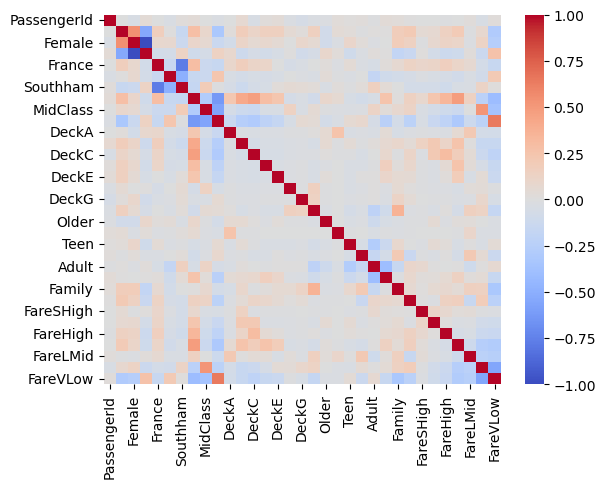

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass,...,MidLife,Family,Sibling,FareSHigh,FareVHigh,FareHigh,FareMid,FareLMid,FareLow,FareVLow
PassengerId,1.000000,-0.005007,-0.042939,0.042939,-0.001205,-0.033606,0.022148,0.034303,-0.000086,-0.029486,...,0.036424,0.024485,0.007036,-0.006919,-0.005924,-0.009361,-0.002941,0.017128,-0.042719,0.015639
Survived,-0.005007,1.000000,0.543351,-0.543351,0.168240,0.003650,-0.155660,0.285904,0.093349,-0.322308,...,0.006572,0.172991,0.203889,0.050561,0.067105,0.143946,0.201847,-0.008940,0.071710,-0.295081
Female,-0.042939,0.543351,1.000000,-1.000000,0.082853,0.074115,-0.125722,0.098013,0.064746,-0.137143,...,-0.004110,0.185204,0.147900,-0.014396,0.077758,0.122850,0.107539,-0.018528,0.125753,-0.263751
Male,0.042939,-0.543351,-1.000000,1.000000,-0.082853,-0.074115,0.125722,-0.098013,-0.064746,0.137143,...,0.004110,-0.185204,-0.147900,0.014396,-0.077758,-0.122850,-0.107539,0.018528,-0.125753,0.263751
France,-0.001205,0.168240,0.082853,-0.082853,1.000000,-0.148258,-0.778359,0.296423,-0.125416,-0.153329,...,0.015701,0.066061,0.125914,0.096390,0.114332,0.158595,0.102301,0.069078,-0.072845,-0.156019
Ireland,-0.033606,0.003650,0.074115,-0.074115,-0.148258,1.000000,-0.496624,-0.155342,-0.127301,0.237449,...,-0.098545,-0.080828,-0.054904,-0.020654,-0.044163,-0.061261,-0.089749,-0.035852,-0.089171,0.205731
Southham,0.022148,-0.155660,-0.125722,0.125722,-0.778359,-0.496624,1.000000,-0.170379,0.192061,-0.009511,...,0.043355,-0.004639,-0.073577,-0.070928,-0.071466,-0.099133,-0.046560,-0.036188,0.123274,0.011096
UpperClass,0.034303,0.285904,0.098013,-0.098013,0.296423,-0.155342,-0.170379,1.000000,-0.288585,-0.626738,...,0.250065,0.015211,0.147762,0.079537,0.235222,0.338436,0.479998,0.143451,-0.229445,-0.407726
MidClass,-0.000086,0.093349,0.064746,-0.064746,-0.125416,-0.127301,0.192061,-0.288585,1.000000,-0.565210,...,0.026835,0.076022,0.117762,-0.034258,-0.073253,-0.101613,-0.130000,-0.003508,0.521150,-0.362614
WorkClass,-0.029486,-0.322308,-0.137143,0.137143,-0.153329,0.237449,-0.009511,-0.626738,-0.565210,1.000000,...,-0.237297,-0.074977,-0.223154,-0.040648,-0.143050,-0.208900,-0.307767,-0.120743,-0.226451,0.646414


In [42]:
numerical_df = strat_titanic_data.select_dtypes(include=[np.number])
#numerical_df = numerical_df.drop(["PassengerId"], axis=1)
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()
correlation_matrix

In [85]:
#strat_titanic_data_age = strat_titanic_data_age.reset_index(drop=True)
#strat_titanic_data_age = strat_titanic_data_age.drop(["PassengerId"], axis=1)
#split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
#for train_indices, valid_indices in split.split(strat_titanic_data_age, strat_titanic_data_age[["Survived", "Female"]]):
#    strat_train_set = strat_titanic_data_age.loc[train_indices]
#    strat_valid_set = strat_titanic_data_age.loc[valid_indices]

In [43]:
#strat_titanic_data.iloc[AgeNaN.head(11).index]["MidLife"] = 1
#strat_titanic_data = strat_titanic_data.drop(["MidLife"], axis=1)
strat_titanic_data = strat_titanic_data.drop(["PassengerId", "Ireland"], axis=1)
#strat_titanic_data = strat_titanic_data.drop(["PassengerId", "Ireland", "Bstard"], axis=1)
#strat_titanic_data = strat_titanic_data.drop(["PassengerId", "Ireland", "Child", "FareLMid", "Bstard", "Adult", "MidLife"], axis=1)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, valid_indices in split.split(strat_titanic_data, strat_titanic_data[["Survived", "Female"]]):
    strat_train_set = strat_titanic_data.loc[train_indices]
    strat_valid_set = strat_titanic_data.loc[valid_indices]

In [44]:
strat_train_set.head(11)

,Survived,Female,Male,France,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,...,MidLife,Family,Sibling,FareSHigh,FareVHigh,FareHigh,FareMid,FareLMid,FareLow,FareVLow
225,0,0,1,0,1,0,0,1,0,0,...,0,2,3,0,0,0,0,0,0,1
600,1,1,0,0,1,0,1,0,0,0,...,0,4,4,0,0,0,0,0,1,0
795,0,0,1,0,1,0,1,0,0,0,...,0,2,3,0,0,0,0,0,1,0
74,1,0,1,0,1,0,0,1,0,0,...,0,2,3,0,0,0,1,0,0,0
49,0,1,0,0,1,0,0,1,0,0,...,0,2,5,0,0,0,0,0,1,0
390,1,0,1,0,1,1,0,0,0,1,...,0,3,5,0,0,1,0,0,0,0
271,1,0,1,0,1,0,0,1,0,0,...,0,2,3,0,0,0,0,0,0,1
706,1,1,0,0,1,0,1,0,0,0,...,1,2,3,0,0,0,0,0,1,0
711,0,0,1,0,1,1,0,0,0,0,...,0,2,3,0,0,0,0,0,1,0
236,0,0,1,0,1,0,1,0,0,0,...,1,2,5,0,0,0,0,0,1,0


In [45]:
strat_valid_set.head(11)

,Survived,Female,Male,France,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,...,MidLife,Family,Sibling,FareSHigh,FareVHigh,FareHigh,FareMid,FareLMid,FareLow,FareVLow
392,0,0,1,0,1,0,0,1,0,0,...,0,2,4,0,0,0,0,0,0,1
359,1,1,0,0,0,0,0,1,0,0,...,0,2,3,0,0,0,0,0,0,1
724,1,0,1,0,1,1,0,0,0,0,...,0,2,5,0,0,0,1,0,0,0
702,0,1,0,1,0,0,0,1,0,0,...,0,4,3,0,0,0,0,0,1,0
413,0,0,1,0,1,0,1,0,0,0,...,0,2,3,0,0,0,0,0,0,1
141,1,1,0,0,1,0,0,1,0,0,...,0,2,3,0,0,0,0,0,0,1
336,0,0,1,0,1,1,0,0,0,0,...,0,2,5,0,0,0,1,0,0,0
206,0,0,1,0,1,0,0,1,0,0,...,0,2,5,0,0,0,0,0,1,0
581,1,1,0,1,0,1,0,0,0,0,...,0,4,5,0,0,1,0,0,0,0
436,0,1,0,0,1,0,0,1,0,0,...,0,3,4,0,0,0,0,1,0,0


In [46]:
print(strat_train_set.info(), strat_valid_set.info())

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 225 to 812
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Survived    712 non-null    int64
 1   Female      712 non-null    int64
 2   Male        712 non-null    int64
 3   France      712 non-null    int64
 4   Southham    712 non-null    int64
 5   UpperClass  712 non-null    int64
 6   MidClass    712 non-null    int64
 7   WorkClass   712 non-null    int64
 8   DeckA       712 non-null    int64
 9   DeckB       712 non-null    int64
 10  DeckC       712 non-null    int64
 11  DeckD       712 non-null    int64
 12  DeckE       712 non-null    int64
 13  DeckF       712 non-null    int64
 14  DeckG       712 non-null    int64
 15  Infant      712 non-null    int64
 16  Older       712 non-null    int64
 17  VOld        712 non-null    int64
 18  Teen        712 non-null    int64
 19  Child       712 non-null    int64
 20  Adult       712 non-null    int64
 

<function matplotlib.pyplot.show(close=None, block=None)>

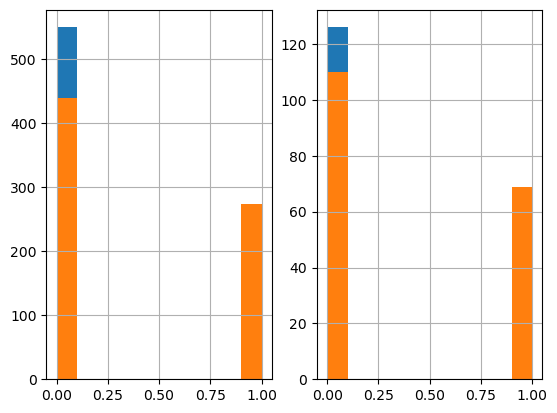

In [46]:
plt.subplot(1,2,1)
strat_train_set['UpperClass'].hist()
strat_train_set['Survived'].hist()

plt.subplot(1,2,2)
strat_valid_set['UpperClass'].hist()
strat_valid_set['Survived'].hist()

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

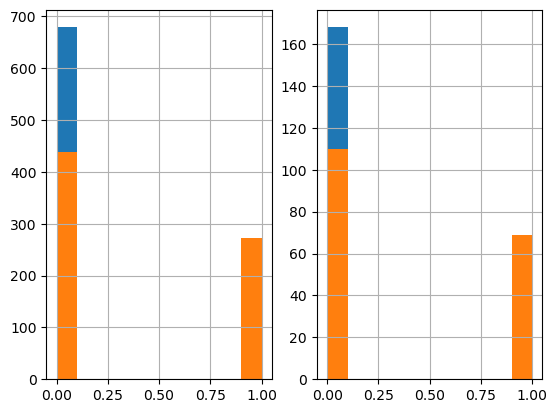

In [47]:
plt.subplot(1,2,1)
strat_train_set['Infant'].hist()
strat_train_set['Survived'].hist()

plt.subplot(1,2,2)
strat_valid_set['Infant'].hist()
strat_valid_set['Survived'].hist()

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

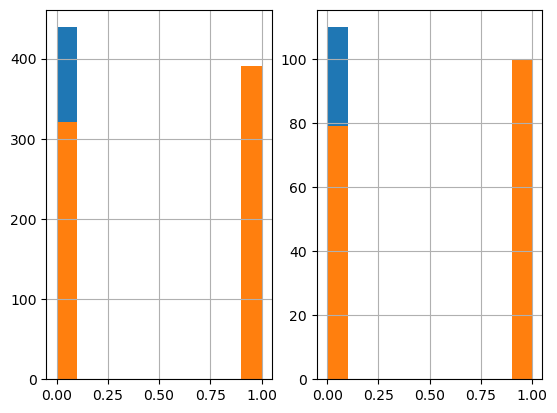

In [48]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['WorkClass'].hist()

plt.subplot(1,2,2)
strat_valid_set['Survived'].hist()
strat_valid_set['WorkClass'].hist()

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

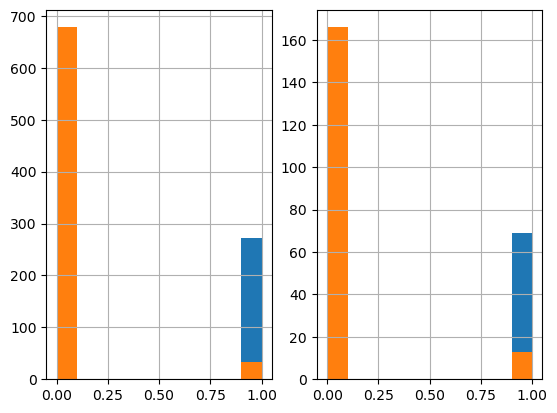

In [49]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['DeckB'].hist()

plt.subplot(1,2,2)
strat_valid_set['Survived'].hist()
strat_valid_set['DeckB'].hist()

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

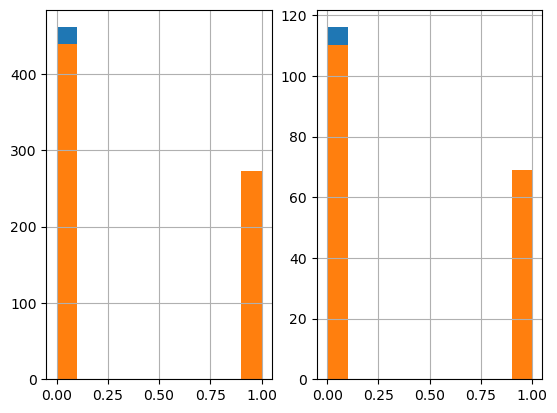

In [50]:
plt.subplot(1,2,1)
strat_train_set['Female'].hist()
strat_train_set['Survived'].hist()

plt.subplot(1,2,2)
strat_valid_set['Female'].hist()
strat_valid_set['Survived'].hist()

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

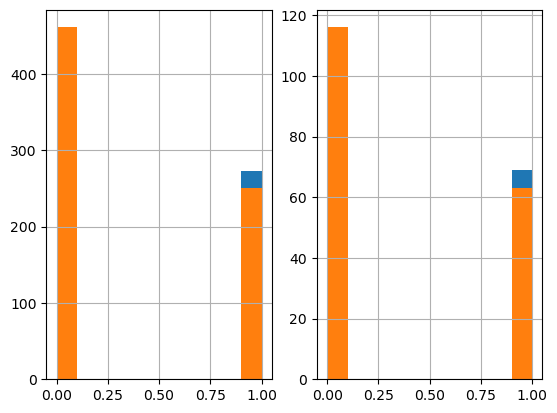

In [51]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Female'].hist()

plt.subplot(1,2,2)
strat_valid_set['Survived'].hist()
strat_valid_set['Female'].hist()

plt.show

In [47]:
X = strat_train_set.drop(['Survived'], axis=1)
y = strat_train_set['Survived']
Xv = strat_valid_set.drop(['Survived'], axis=1)
yv = strat_valid_set['Survived']

#X, y = load_iris(return_X_y=True)
#scaler = StandardScaler()
#X_data = scaler.fit_transform(X)
#Xv_data = scaler.fit_transform(Xv)
X_data = X
Xv_data = Xv
y_data = y.to_numpy()
yv_data = yv.to_numpy()
X, y = load_iris(return_X_y=True)
Xv, yv = load_iris(return_X_y=True)
X_dataNB = X
Xv_dataNB = Xv
y_dataNB = y
yv_dataNB = yv

In [48]:
strat_train_set.head(11)

,Survived,Female,Male,France,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,...,MidLife,Family,Sibling,FareSHigh,FareVHigh,FareHigh,FareMid,FareLMid,FareLow,FareVLow
225,0,0,1,0,1,0,0,1,0,0,...,0,2,3,0,0,0,0,0,0,1
600,1,1,0,0,1,0,1,0,0,0,...,0,4,4,0,0,0,0,0,1,0
795,0,0,1,0,1,0,1,0,0,0,...,0,2,3,0,0,0,0,0,1,0
74,1,0,1,0,1,0,0,1,0,0,...,0,2,3,0,0,0,1,0,0,0
49,0,1,0,0,1,0,0,1,0,0,...,0,2,5,0,0,0,0,0,1,0
390,1,0,1,0,1,1,0,0,0,1,...,0,3,5,0,0,1,0,0,0,0
271,1,0,1,0,1,0,0,1,0,0,...,0,2,3,0,0,0,0,0,0,1
706,1,1,0,0,1,0,1,0,0,0,...,1,2,3,0,0,0,0,0,1,0
711,0,0,1,0,1,1,0,0,0,0,...,0,2,3,0,0,0,0,0,1,0
236,0,0,1,0,1,0,1,0,0,0,...,1,2,5,0,0,0,0,0,1,0


In [49]:
X_data

,Female,Male,France,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,DeckC,...,MidLife,Family,Sibling,FareSHigh,FareVHigh,FareHigh,FareMid,FareLMid,FareLow,FareVLow
225,0,1,0,1,0,0,1,0,0,0,...,0,2,3,0,0,0,0,0,0,1
600,1,0,0,1,0,1,0,0,0,0,...,0,4,4,0,0,0,0,0,1,0
795,0,1,0,1,0,1,0,0,0,0,...,0,2,3,0,0,0,0,0,1,0
74,0,1,0,1,0,0,1,0,0,0,...,0,2,3,0,0,0,1,0,0,0
49,1,0,0,1,0,0,1,0,0,0,...,0,2,5,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,1,0,1,0,0,0,1,0,0,0,...,0,4,4,0,0,0,0,0,1,0
275,1,0,0,1,1,0,0,0,0,0,...,1,2,5,0,0,0,1,0,0,0
859,0,1,1,0,0,0,1,0,0,0,...,0,2,3,0,0,0,0,0,0,1
25,1,0,0,1,0,0,1,0,0,0,...,0,1,5,0,0,0,0,1,0,0


In [50]:
Xv_data

,Female,Male,France,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,DeckC,...,MidLife,Family,Sibling,FareSHigh,FareVHigh,FareHigh,FareMid,FareLMid,FareLow,FareVLow
392,0,1,0,1,0,0,1,0,0,0,...,0,2,4,0,0,0,0,0,0,1
359,1,0,0,0,0,0,1,0,0,0,...,0,2,3,0,0,0,0,0,0,1
724,0,1,0,1,1,0,0,0,0,0,...,0,2,5,0,0,0,1,0,0,0
702,1,0,1,0,0,0,1,0,0,0,...,0,4,3,0,0,0,0,0,1,0
413,0,1,0,1,0,1,0,0,0,0,...,0,2,3,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,1,0,0,0,0,0,1,0,0,0,...,0,2,3,0,0,0,0,0,0,1
63,0,1,0,1,0,0,1,0,0,0,...,0,3,2,0,0,0,0,0,1,0
783,0,1,0,1,0,0,1,0,0,0,...,0,3,5,0,0,0,0,0,1,0
519,0,1,0,1,0,0,1,0,0,0,...,0,2,3,0,0,0,0,0,0,1


In [51]:
y_data

array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,

In [52]:
yv_data

array([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0])

In [53]:
reg = LinearRegression()
reg.fit(X_data, y_data)
predict_ys1 = reg.predict(X_data)
predict_ys2 = np.round(predict_ys1)
predict_y = predict_ys2.astype(int)
predict_y

array([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,

In [54]:
Xv_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 392 to 293
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Female      179 non-null    int64
 1   Male        179 non-null    int64
 2   France      179 non-null    int64
 3   Southham    179 non-null    int64
 4   UpperClass  179 non-null    int64
 5   MidClass    179 non-null    int64
 6   WorkClass   179 non-null    int64
 7   DeckA       179 non-null    int64
 8   DeckB       179 non-null    int64
 9   DeckC       179 non-null    int64
 10  DeckD       179 non-null    int64
 11  DeckE       179 non-null    int64
 12  DeckF       179 non-null    int64
 13  DeckG       179 non-null    int64
 14  Infant      179 non-null    int64
 15  Older       179 non-null    int64
 16  VOld        179 non-null    int64
 17  Teen        179 non-null    int64
 18  Child       179 non-null    int64
 19  Adult       179 non-null    int64
 20  MidLife     179 non-null    int64
 

In [55]:
print(Xv_data)
predict_yvs1 = reg.predict(Xv_data)
print(predict_yvs1)
predict_yvs2 = np.round(predict_yvs1)
print(predict_yvs2)
predict_yv = predict_yvs2.astype(int)
print(predict_yv)

     Female  Male  France  Southham  UpperClass  MidClass  WorkClass  DeckA  \
392       0     1       0         1           0         0          1      0   
359       1     0       0         0           0         0          1      0   
724       0     1       0         1           1         0          0      0   
702       1     0       1         0           0         0          1      0   
413       0     1       0         1           0         1          0      0   
..      ...   ...     ...       ...         ...       ...        ...    ...   
82        1     0       0         0           0         0          1      0   
63        0     1       0         1           0         0          1      0   
783       0     1       0         1           0         0          1      0   
519       0     1       0         1           0         0          1      0   
293       1     0       0         1           0         0          1      0   

     DeckB  DeckC  ...  MidLife  Family  Sibling  F

In [56]:
print('Accuracy:', accuracy_score(yv_data, predict_yv))
print('Precision:', precision_score(yv_data, predict_yv))

Accuracy: 0.8212290502793296
Precision: 0.7846153846153846


In [81]:
print('Accuracy:', accuracy_score(yv_data, predict_yv))

Accuracy: 0.7988826815642458


In [58]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)
#print(predict_yv)
#print(predict_y)

Accuracy: 0.8398876404494382 Precision: 0.8192771084337349 Recall: 0.7472527472527473 F1_score: 0.7816091954022989
Accuracy: 0.8212290502793296 Precision: 0.7846153846153846 Recall: 0.7391304347826086 F1_score: 0.7611940298507462
[[394  45]
 [ 69 204]]
[[96 14]
 [18 51]]


In [60]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.8398876404494382 Precision: 0.8192771084337349 Recall: 0.7472527472527473 F1_score: 0.7816091954022989
Accuracy: 0.8212290502793296 Precision: 0.7846153846153846 Recall: 0.7391304347826086 F1_score: 0.7611940298507462
[[394  45]
 [ 69 204]]
[[96 14]
 [18 51]]


In [105]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predicit_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.8146067415730337 Precision: 0.7680608365019012 Recall: 0.73992673992674 F1_score: 0.753731343283582
Accuracy: 0.8324022346368715 Precision: 0.8 Recall: 0.7536231884057971 F1_score: 0.7761194029850746
[[378  61]
 [ 71 202]]
[[97 13]
 [17 52]]


In [62]:
print("Running........")

reg = LogisticRegression()

params = {'C': [1, 10]}

grid_search = GridSearchCV(estimator=reg, param_grid=params, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data, y_data)
print("Complete", grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_)
regT = grid_search.best_estimator_
regT.fit(X_data, y_data)
predict_y = regT.predict(X_data)
predict_yv = regT.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predict_yv = predict_yv.astype(int)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Running........
Complete {'C': 1} 0.8117206736925047 LogisticRegression(C=1)
Accuracy: 0.8384831460674157 Precision: 0.8015267175572519 Recall: 0.7692307692307693 F1_score: 0.7850467289719626
Accuracy: 0.8100558659217877 Precision: 0.7536231884057971 Recall: 0.7536231884057971 F1_score: 0.7536231884057971
[[387  52]
 [ 63 210]]
[[93 17]
 [17 52]]


In [239]:
print(grid_search.best_estimator_)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predicit_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

LogisticRegression(C=10)
Accuracy: 0.8202247191011236 Precision: 0.7756653992395437 Recall: 0.7472527472527473 F1_score: 0.7611940298507462
Accuracy: 0.8212290502793296 Precision: 0.796875 Recall: 0.7391304347826086 F1_score: 0.7669172932330827
[[380  59]
 [ 69 204]]
[[97 13]
 [18 51]]


In [63]:
regT = grid_search.best_estimator_
regT.fit(X_data, y_data)
predict_y = regT.predict(X_data)
predict_yv = regT.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)
print(regT)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predicit_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

LogisticRegression(C=1)
Accuracy: 0.8384831460674157 Precision: 0.8015267175572519 Recall: 0.7692307692307693 F1_score: 0.7850467289719626
Accuracy: 0.8100558659217877 Precision: 0.7536231884057971 Recall: 0.7536231884057971 F1_score: 0.7536231884057971
[[387  52]
 [ 63 210]]
[[93 17]
 [17 52]]


In [64]:
print("Running.........")

tree = DecisionTreeClassifier()

params = {
    'max_depth': [1, 3, 5, 7, 10, 12, 15, 17, 20, 24, 26, 28]
}

grid_search = GridSearchCV(estimator=tree, param_grid=params, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data, y_data)

print("Complete")
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
treeT = grid_search.best_estimator_
treeT.fit(X_data, y_data)
predict_y = treeT.predict(X_data)
predict_yv = treeT.predict(Xv_data)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Running.........
Complete
{'max_depth': 5}
0.8159460258051808
DecisionTreeClassifier(max_depth=5)
Accuracy: 0.851123595505618 Precision: 0.9113300492610837 Recall: 0.6776556776556777 F1_score: 0.7773109243697479
Accuracy: 0.8156424581005587 Precision: 0.8103448275862069 Recall: 0.6811594202898551 F1_score: 0.7401574803149606
[[421  18]
 [ 88 185]]
[[99 11]
 [22 47]]


In [65]:
print(grid_search.best_estimator_)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predicit_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

DecisionTreeClassifier(max_depth=5)
Accuracy: 0.851123595505618 Precision: 0.9113300492610837 Recall: 0.6776556776556777 F1_score: 0.7773109243697479
Accuracy: 0.8100558659217877 Precision: 0.8103448275862069 Recall: 0.6811594202898551 F1_score: 0.7401574803149606
[[421  18]
 [ 88 185]]
[[99 11]
 [22 47]]


In [66]:
treeT = DecisionTreeClassifier(max_depth=3)

treeT.fit(X_data, y_data)
predict_y = treeT.predict(X_data)
predict_yv = treeT.predict(Xv_data)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predicit_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.8258426966292135 Precision: 0.8941798941798942 Recall: 0.6190476190476191 F1_score: 0.7316017316017316
Accuracy: 0.8100558659217877 Precision: 0.8823529411764706 Recall: 0.6521739130434783 F1_score: 0.75
[[419  20]
 [104 169]]
[[104   6]
 [ 24  45]]


In [67]:
for i in range(len(yv_data)):
    if (yv_data[i] == predict_yv[i]):
        print('match:', i, yv_data[i], predict_yv[i])
    else:
        print(yv_data[i], predict_yv[i], i)

match: 0 0 0
match: 1 1 1
1 0 2
0 1 3
match: 4 0 0
1 0 5
match: 6 0 0
match: 7 0 0
match: 8 1 1
match: 9 0 0
match: 10 0 0
match: 11 1 1
match: 12 0 0
match: 13 0 0
match: 14 0 0
match: 15 0 0
match: 16 0 0
match: 17 0 0
match: 18 1 1
0 1 19
1 0 20
match: 21 0 0
match: 22 0 0
match: 23 0 0
match: 24 1 1
match: 25 1 1
match: 26 1 1
match: 27 0 0
match: 28 0 0
match: 29 0 0
match: 30 0 0
match: 31 0 0
match: 32 0 0
match: 33 1 1
match: 34 1 1
match: 35 0 0
match: 36 0 0
match: 37 1 1
match: 38 0 0
match: 39 0 0
match: 40 0 0
match: 41 0 0
0 1 42
match: 43 0 0
match: 44 0 0
match: 45 0 0
match: 46 1 1
match: 47 0 0
match: 48 0 0
match: 49 1 1
match: 50 0 0
match: 51 0 0
match: 52 0 0
0 1 53
match: 54 0 0
match: 55 0 0
match: 56 0 0
match: 57 0 0
match: 58 0 0
match: 59 1 1
match: 60 0 0
1 0 61
match: 62 0 0
match: 63 0 0
match: 64 0 0
match: 65 0 0
match: 66 0 0
match: 67 1 1
match: 68 0 0
match: 69 1 1
match: 70 0 0
match: 71 1 1
1 0 72
match: 73 1 1
match: 74 0 0
1 0 75
match: 76 0 0
ma

In [75]:
print(Xv_data.iloc[19])
print(strat_titanic_data.iloc[455])
print(titanic_data.iloc[455])

Female        0
Male          1
France        0
Southham      1
UpperClass    1
MidClass      0
WorkClass     0
DeckA         0
DeckB         0
DeckC         1
DeckD         0
DeckE         0
DeckF         0
DeckG         0
Infant        0
Older         0
VOld          0
Teen          0
Child         0
Adult         1
MidLife       0
Family        2
Sibling       5
FareSHigh     0
FareVHigh     0
FareHigh      0
FareMid       1
FareLMid      0
FareLow       0
FareVLow      0
Name: 137, dtype: int64
Survived      1
Female        0
Male          1
France        1
Southham      0
UpperClass    0
MidClass      0
WorkClass     1
DeckA         0
DeckB         0
DeckC         0
DeckD         0
DeckE         0
DeckF         0
DeckG         0
Infant        0
Older         0
VOld          0
Teen          0
Child         0
Adult         1
MidLife       0
Family        2
Sibling       3
FareSHigh     0
FareVHigh     0
FareHigh      0
FareMid       0
FareLMid      0
FareLow       0
FareVLow      1


In [76]:
Xv_data.iloc[10]

Female        0
Male          1
France        0
Southham      1
UpperClass    1
MidClass      0
WorkClass     0
DeckA         0
DeckB         0
DeckC         1
DeckD         0
DeckE         0
DeckF         0
DeckG         0
Infant        0
Older         0
VOld          0
Teen          0
Child         0
Adult         1
MidLife       0
Family        2
Sibling       5
FareSHigh     0
FareVHigh     0
FareHigh      0
FareMid       1
FareLMid      0
FareLow       0
FareVLow      0
Name: 137, dtype: int64

In [68]:
treeT = DecisionTreeClassifier(max_depth=10)

treeT.fit(X_data, y_data)
predict_y = treeT.predict(X_data)
predict_yv = treeT.predict(Xv_data)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predicit_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.8960674157303371 Precision: 0.9234042553191489 Recall: 0.7948717948717948 F1_score: 0.8543307086614174
Accuracy: 0.8100558659217877 Precision: 0.7575757575757576 Recall: 0.7246376811594203 F1_score: 0.7407407407407407
[[421  18]
 [ 56 217]]
[[94 16]
 [19 50]]


In [69]:
print("Running.........")

clf = ensemble.RandomForestClassifier()

params = {
    'n_estimators': [10, 100, 200, 300, 500], 
    'max_depth': [None, 5, 10, 15, 20, 24, 26, 28], 
    'min_samples_split': [2,3,4,5,10],
    'min_samples_leaf': [1,2,4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data, y_data)

print("Complete")
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
forclfT = grid_search.best_estimator_
#forclfT = ensemble.RandomForestClassifier(n_estimators=100, max_depth=5, max_features='sqrt', min_samples_leaf=4, min_samples_split=2)
forclfT.fit(X_data, y_data)
predict_y = forclfT.predict(X_data)
predict_yv = forclfT.predict(Xv_data)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Running.........
Complete
{'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
0.8257854821235103
RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=2,
                       n_estimators=10)
Accuracy: 0.8623595505617978 Precision: 0.8820960698689956 Recall: 0.73992673992674 F1_score: 0.8047808764940239
Accuracy: 0.7988826815642458 Precision: 0.7619047619047619 Recall: 0.6956521739130435 F1_score: 0.7272727272727273
[[412  27]
 [ 71 202]]
[[95 15]
 [21 48]]


In [79]:
print(grid_search.best_estimator_)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=300)
Accuracy: 0.9030898876404494 Precision: 0.908 Recall: 0.8315018315018315 F1_score: 0.8680688336520076
Accuracy: 0.8100558659217877 Precision: 0.7878787878787878 Recall: 0.7536231884057971 F1_score: 0.7703703703703704
[[416  23]
 [ 46 227]]
[[96 14]
 [17 52]]


In [70]:
#forclfT = grid_search.best_estimator_
forclfT = ensemble.RandomForestClassifier(n_estimators=200, max_depth=20, max_features='log2', min_samples_leaf=4, min_samples_split=4)
#forclfT = ensemble.RandomForestClassifier(n_estimators=100, max_depth=20, max_features='sqrt', min_samples_leaf=4, min_samples_split=4)
forclfT.fit(X_data, y_data)
predict_y = forclfT.predict(X_data)
predict_yv = forclfT.predict(Xv_data)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.8426966292134831 Precision: 0.8851674641148325 Recall: 0.6776556776556777 F1_score: 0.7676348547717843
Accuracy: 0.8212290502793296 Precision: 0.8363636363636363 Recall: 0.6666666666666666 F1_score: 0.7419354838709677
[[415  24]
 [ 88 185]]
[[101   9]
 [ 23  46]]


In [71]:
forestT = ensemble.RandomForestClassifier(n_estimators=100, max_depth=20, max_features='sqrt', min_samples_leaf=4, min_samples_split=4)
forestT.fit(X_data, y_data)
predict_y = forestT.predict(X_data)
predict_yv = forestT.predict(Xv_data)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predicit_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.8469101123595506 Precision: 0.8693693693693694 Recall: 0.706959706959707 F1_score: 0.7797979797979798
Accuracy: 0.8100558659217877 Precision: 0.8070175438596491 Recall: 0.6666666666666666 F1_score: 0.7301587301587301
[[410  29]
 [ 80 193]]
[[99 11]
 [23 46]]


In [331]:
print(forestT)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=4)
Accuracy: 0.8539325842696629 Precision: 0.8823529411764706 Recall: 0.7142857142857143 F1_score: 0.7894736842105263
Accuracy: 0.8268156424581006 Precision: 0.9038461538461539 Recall: 0.6811594202898551 F1_score: 0.7768595041322314
[[413  26]
 [ 78 195]]
[[105   5]
 [ 22  47]]


In [72]:
print("Running.........")

model = KNeighborsClassifier()

params = [
    {"n_neighbors": [1, 5, 10, 15, 20]
}]

grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data, y_data)
#grid_search.predict(X_data)

print("Complete")
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
modelT = grid_search.best_estimator_
modelT.fit(X_data, y_data)
predict_y = modelT.predict(X_data)
predict_yv = modelT.predict(Xv_data)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Running.........
Complete
{'n_neighbors': 10}
0.8032896680784004
KNeighborsClassifier(n_neighbors=10)
Accuracy: 0.8328651685393258 Precision: 0.84375 Recall: 0.6923076923076923 F1_score: 0.7605633802816901
Accuracy: 0.8044692737430168 Precision: 0.8148148148148148 Recall: 0.6376811594202898 F1_score: 0.7154471544715447
[[404  35]
 [ 84 189]]
[[100  10]
 [ 25  44]]


In [73]:
print(grid_search.best_estimator_)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

KNeighborsClassifier(n_neighbors=10)
Accuracy: 0.8328651685393258 Precision: 0.84375 Recall: 0.6923076923076923 F1_score: 0.7605633802816901
Accuracy: 0.8044692737430168 Precision: 0.8148148148148148 Recall: 0.6376811594202898 F1_score: 0.7154471544715447
[[404  35]
 [ 84 189]]
[[100  10]
 [ 25  44]]


In [74]:
modelT = KNeighborsClassifier(n_neighbors=8)
modelT.fit(X_data, y_data)
predict_y = modelT.predict(X_data)
predict_yv = modelT.predict(Xv_data)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.827247191011236 Precision: 0.8378378378378378 Recall: 0.6813186813186813 F1_score: 0.7515151515151515
Accuracy: 0.7877094972067039 Precision: 0.7818181818181819 Recall: 0.6231884057971014 F1_score: 0.6935483870967742
[[403  36]
 [ 87 186]]
[[98 12]
 [26 43]]


In [75]:
max_depth = 20
bestdepth = -1
bestscore = 0
for i in range(max_depth):
    tree = DecisionTreeClassifier(max_depth=i+1)
    tree.fit(X_data, y_data)
    predict_y = tree.predict(X_data)
    trainscore = accuracy_score(y_data, predict_y)
    print('Depth:', i+1, 'Train Score:', trainscore)
    if (trainscore > bestscore):
        bestscore = trainscore
        bestdepth = i+1
    print('Best Depth:', bestdepth, 'Best Score:', bestscore)
print(accuracy_score(y_data, predict_y))

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
#print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cmtree = confusion_matrix(y_data, predict_y)
print(cmtree)

bestdepth = -1
bestscore = 0
estimators = [10, 100, 200, 300, 500]
bestestimator = 1
for i in range(max_depth):
    for e in (estimators):
        ranforest = ensemble.RandomForestClassifier(n_estimators=e, max_depth=i+1)
        ranforest.fit(X_data, y_data)
        predicit_y = ranforest.predict(X_data)
        ranscore = accuracy_score(y_data, predict_y)
        print('n_estimators:', e, 'Depth:', i+1, 'Score:', ranscore)
        if (ranscore > bestscore):
            bestscore = ranscore
            bestdepth = i+1
            bestestimator = e
        print('Best n_estimators:', bestestimator, 'Best Depth:', bestdepth, 'Best Score:', bestscore)
cmran = confusion_matrix(y_data, predict_y)
print(cmran)

Depth: 1 Train Score: 0.7865168539325843
Best Depth: 1 Best Score: 0.7865168539325843
Depth: 2 Train Score: 0.7963483146067416
Best Depth: 2 Best Score: 0.7963483146067416
Depth: 3 Train Score: 0.8258426966292135
Best Depth: 3 Best Score: 0.8258426966292135
Depth: 4 Train Score: 0.8384831460674157
Best Depth: 4 Best Score: 0.8384831460674157
Depth: 5 Train Score: 0.851123595505618
Best Depth: 5 Best Score: 0.851123595505618
Depth: 6 Train Score: 0.8581460674157303
Best Depth: 6 Best Score: 0.8581460674157303
Depth: 7 Train Score: 0.8693820224719101
Best Depth: 7 Best Score: 0.8693820224719101
Depth: 8 Train Score: 0.8820224719101124
Best Depth: 8 Best Score: 0.8820224719101124
Depth: 9 Train Score: 0.8904494382022472
Best Depth: 9 Best Score: 0.8904494382022472
Depth: 10 Train Score: 0.8960674157303371
Best Depth: 10 Best Score: 0.8960674157303371
Depth: 11 Train Score: 0.9030898876404494
Best Depth: 11 Best Score: 0.9030898876404494
Depth: 12 Train Score: 0.9087078651685393
Best Depth

In [77]:
#treeT = DecisionTreeClassifier(max_depth=28)
treeT = DecisionTreeClassifier(max_depth=16)
treeT.fit(X_data, y_data)
predict_y = treeT.predict(X_data)
predict_yv = treeT.predict(Xv_data)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predicit_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

#ranforestT = ensemble.RandomForestClassifier(n_estimators=500, max_depth=28)
ranforestT = ensemble.RandomForestClassifier(n_estimators=10, max_depth=1)
ranforestT.fit(X_data, y_data)
predict_y = ranforestT.predict(X_data)
predict_yv = ranforestT.predict(Xv_data)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.9129213483146067 Precision: 0.9377593360995851 Recall: 0.8278388278388278 F1_score: 0.8793774319066148
Accuracy: 0.8100558659217877 Precision: 0.746268656716418 Recall: 0.7246376811594203 F1_score: 0.7352941176470589
[[424  15]
 [ 47 226]]
[[93 17]
 [19 50]]
Accuracy: 0.6825842696629213 Precision: 0.9433962264150944 Recall: 0.18315018315018314 F1_score: 0.3067484662576687
Accuracy: 0.6815642458100558 Precision: 1.0 Recall: 0.17391304347826086 F1_score: 0.2962962962962963
[[436   3]
 [223  50]]
[[110   0]
 [ 57  12]]


In [78]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_data, y_data)
predict_y = neigh.predict(X_data)
pretict_yv = neigh.predict(Xv_data)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv= confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.8876404494382022 Precision: 0.8784313725490196 Recall: 0.8205128205128205 F1_score: 0.8484848484848485
Accuracy: 0.6815642458100558 Precision: 1.0 Recall: 0.17391304347826086 F1_score: 0.2962962962962963
[[408  31]
 [ 49 224]]
[[110   0]
 [ 57  12]]


In [79]:
print(neigh)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv= confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

KNeighborsClassifier(n_neighbors=1)
Accuracy: 0.8876404494382022 Precision: 0.8784313725490196 Recall: 0.8205128205128205 F1_score: 0.8484848484848485
Accuracy: 0.6815642458100558 Precision: 1.0 Recall: 0.17391304347826086 F1_score: 0.2962962962962963
[[408  31]
 [ 49 224]]
[[110   0]
 [ 57  12]]


In [82]:
#X, y = load_iris(return_X_y=True)
#split
model = GaussianProcessRegressor()
gnb = GaussianNB()
#bnb = BernoulliNB()
#cnb = CategoricalNB()
#cpnb = ComplementBN()
#mlnb = MultinomialNB()
gnb.fit(X_data, y_data)
predict_y = gnb.predict(X_data)
predict_yv = gnb.predict(Xv_data)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

nbcm = confusion_matrix(y_data, predict_y)
nbcmv = confusion_matrix(yv_data, predict_yv)
print(nbcm)
print(nbcmv)

Accuracy: 0.7485955056179775 Precision: 0.7098214285714286 Recall: 0.5824175824175825 F1_score: 0.6398390342052314
Accuracy: 0.6815642458100558 Precision: 0.6071428571428571 Recall: 0.4927536231884058 F1_score: 0.544
[[374  65]
 [114 159]]
[[88 22]
 [35 34]]
